In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
np.random.seed(7)

# Problem 1

## 1A) Implement Metroplis-Hasting

In [3]:
%%time

BURN = 100000
N = 50000
tau = [0.01, 0.1, 0.2, 0.5, 1]

def proposal(z, tau):
    return np.random.normal(loc=z, scale=tau)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_transform(x):
    return sigmoid(10 * x + 3)

def scalar_dist(z):
    return np.exp(-(z**2)) * sigmoid(10 * z + 3)

def metropolis_hastings(start, N, x, tau):
    accept = 0
    for i in range(start, start + N):
        u = np.random.uniform(low=0.0, high=1.0)
        x_ = proposal(x[i], tau)
        proportion = scalar_dist(x_) / scalar_dist(x[i])  # using symmetric dist
        if u < np.minimum(1, proportion):
            x[i+1] = x_
            accept += 1
        else:
            x[i+1] = x[i]
    return accept / N

results_tau_accept = {}
results_tau_samples = {}
for t in tau:
    print(f'Running Metropolis-Hastings with tau={t}')
    x = np.zeros(BURN + N + 1)
    _ = metropolis_hastings(0, BURN, x, t)
    print(f'Completed Burn-In with tau={t}')
    accept = metropolis_hastings(BURN, N, x, t)
    results_tau_accept[t] = accept
    results_tau_samples[t] = x
    print(f'Retrieved Samples with tau={t}')

Running Metropolis-Hastings with tau=0.01
Completed Burn-In with tau=0.01
Retrieved Samples with tau=0.01
Running Metropolis-Hastings with tau=0.1
Completed Burn-In with tau=0.1
Retrieved Samples with tau=0.1
Running Metropolis-Hastings with tau=0.2
Completed Burn-In with tau=0.2
Retrieved Samples with tau=0.2
Running Metropolis-Hastings with tau=0.5
Completed Burn-In with tau=0.5
Retrieved Samples with tau=0.5
Running Metropolis-Hastings with tau=1
Completed Burn-In with tau=1
Retrieved Samples with tau=1
Wall time: 21 s


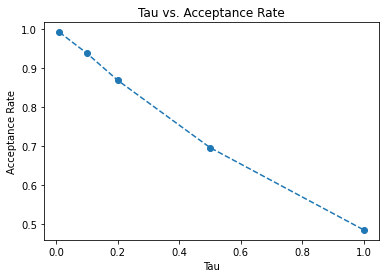

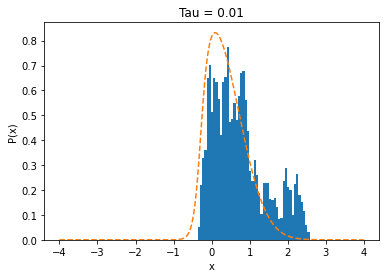

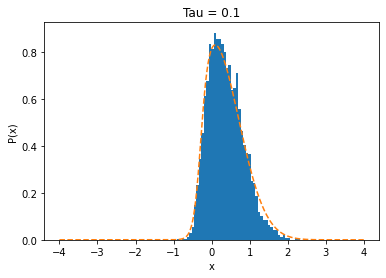

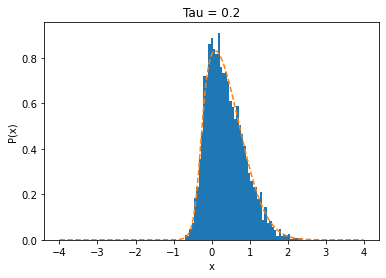

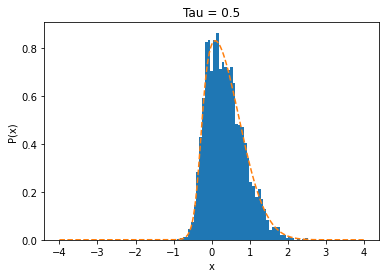

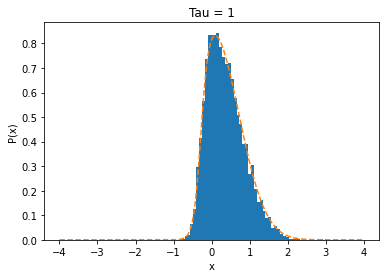

<Figure size 432x288 with 0 Axes>

In [4]:
def plot_tau_v_accept(data):
    x = []
    y = []
    for tau, accept in data.items():
        x.append(tau)
        y.append(accept)
    plt.title("Tau vs. Acceptance Rate")
    plt.xlabel("Tau")
    plt.ylabel("Acceptance Rate")
    plt.scatter(x, y)
    plt.plot(x, y, '--')
    # plt.savefig(f'TauVAcceptance.PDF')
    plt.show()
    plt.clf()
    
def plot_tau_v_sample(data, BURN=100000):
    def quadrature(func, deg=100):
        x, y = np.polynomial.hermite.hermgauss(deg)
        out = func(x)
        return np.sum(out * y)
    # Ground Truth Points
    x_ = np.arange(-4, 4.01, .01)
    normalizer = quadrature(sigmoid_transform)
    y_hat = (np.exp(-x_**2) * sigmoid_transform(x_)) / normalizer
    # Metropolis Hastings Plots
    for tau, sample in data.items():
        x = sample[BURN::10]
        plt.title(f"Tau = {tau}")
        n, bins, _ = plt.hist(x, bins=50, density=True, histtype='bar')
        plt.plot(x_, y_hat, '--')
        plt.xlabel("x")
        plt.ylabel("P(x)")
        # plt.savefig(f'Tau={tau}.PDF')
        plt.show()
        plt.clf()
plot_tau_v_accept(results_tau_accept)
plot_tau_v_sample(results_tau_samples)

## 1B) Implement Hybrid Monte-Carlo sampling with Leapfrog

In [5]:
%%time

BURN = 100000
N = 50000
eps = [0.005, 0.01, 0.1, 0.2, 0.5]

def energy(z, r):
    return -np.log(scalar_dist(z) + 1e-5) + (0.5 * (r**2))  # avoid divide by zero in log

def compute_dz(z):
    return (-2 * z) + (10 * (1 - sigmoid_transform(z)))

def leap_frog(z, r, L, eps):
    dz = -compute_dz(z)
    for _ in range(L):
        r -= 0.5 * eps * dz
        z += eps * r  # s_i = 1
        dz = -compute_dz(z)
        r -= 0.5 * eps * dz
    return z, r, dz

def hybrid_monte_carlo(start, N, z, eps, L=10):
    accept = 0
    for i in range(start, start + N):
        u = np.random.uniform(low=0.0, high=1.0)
        r = np.random.normal(0.0, 1.0)  # s_i = 1
        z_, r_, dz = leap_frog(z[i], r, L, eps)
        r_ = -r_
        if u < np.minimum(1, np.exp(-energy(z_, r_) + energy(z[i], r))):
            z[i + 1] = z_
            accept += 1
    return accept / N

results_eps_accept = {}
results_eps_samples = {}
for e in eps:
    print(f'Running Hybrid Monte Carlo with eps={e}')
    z = np.zeros(BURN + N + 1)
    _ = hybrid_monte_carlo(0, BURN, z, e)
    print(f'Completed Burn-In with eps={e}')
    accept = hybrid_monte_carlo(BURN, N, z, e)
    results_eps_accept[e] = accept
    results_eps_samples[e] = z
    print(f'Retrieved Samples with eps={e}')

Running Hybrid Monte Carlo with eps=0.005
Completed Burn-In with eps=0.005
Retrieved Samples with eps=0.005
Running Hybrid Monte Carlo with eps=0.01
Completed Burn-In with eps=0.01
Retrieved Samples with eps=0.01
Running Hybrid Monte Carlo with eps=0.1
Completed Burn-In with eps=0.1
Retrieved Samples with eps=0.1
Running Hybrid Monte Carlo with eps=0.2
Completed Burn-In with eps=0.2
Retrieved Samples with eps=0.2
Running Hybrid Monte Carlo with eps=0.5
Completed Burn-In with eps=0.5
Retrieved Samples with eps=0.5
Wall time: 1min 31s


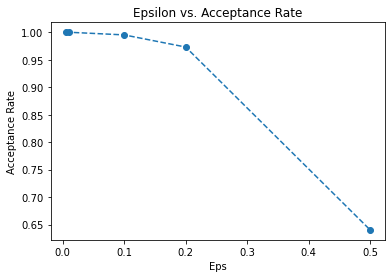

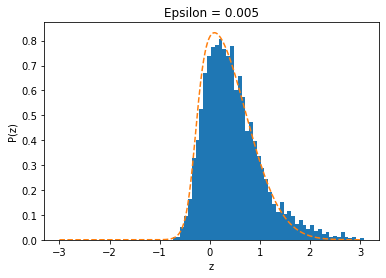

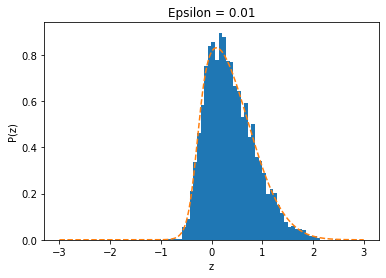

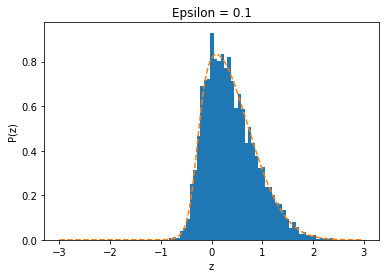

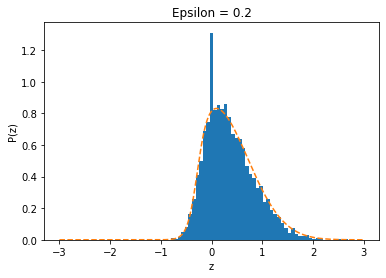

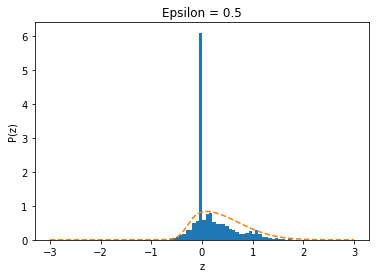

<Figure size 432x288 with 0 Axes>

In [6]:
def plot_eps_v_accept(data):
    x = []
    y = []
    for eps, accept in data.items():
        x.append(eps)
        y.append(accept)
    plt.title("Epsilon vs. Acceptance Rate")
    plt.xlabel("Eps")
    plt.ylabel("Acceptance Rate")
    plt.scatter(x, y)
    plt.plot(x, y, '--')
    # plt.savefig(f'EpsVAcceptance.PDF')
    plt.show()
    plt.clf()
    
def plot_eps_v_sample(data, BURN=100000):
    def quadrature(func, deg=100):
        x, y = np.polynomial.hermite.hermgauss(deg)
        out = func(x)
        return np.sum(out * y)
    # Ground Truth Points
    x_ = np.arange(-3, 3.01, .01)
    normalizer = quadrature(sigmoid_transform)
    y_hat = (np.exp(-x_**2) * sigmoid_transform(x_)) / normalizer
    # Plot hybrid points
    for eps, sample in data.items():
        x = sample[BURN::10]
        plt.title(f"Epsilon = {eps}")
        n, bins, _ = plt.hist(x, bins=50, density=True, histtype='bar')
        plt.plot(x_, y_hat, '--')
        plt.xlabel("z")
        plt.ylabel("P(z)")
        # plt.savefig(f'Eps={eps}.PDF')
        plt.show()
        plt.clf()
plot_eps_v_accept(results_eps_accept)
plot_eps_v_sample(results_eps_samples)

## 1C) What do you conclude?

Both MCMC algorithms perform similarly; however, it appears that Metropolis-Hasting appears to fit the target distribution better over the various scenarios as opposed to the Hybrid Monte-Carlo approach. This can be seen by examining the histogram plot of the Hybrid approach with $\epsilon = 0.5$, which appears to poorly fit the target distribution. Looking at the Metropolis-Hasting output, the algorithm appears to closely match the target distribution over all scenarios. Overall, both algorithms perform well and tend to decrease the number of accepted states as their individual hyper parameters are increased (i.e., tau and epsilon).

# Problem 2

## 2a) Scatter Plot

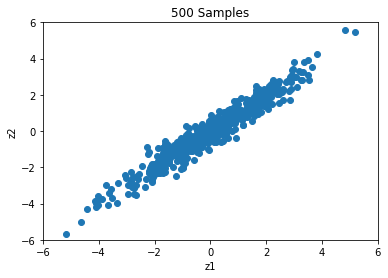

<Figure size 432x288 with 0 Axes>

In [7]:
cov = np.array([[3, 2.9], [2.9, 3]])
mu = np.array([0, 0])

samples = np.random.multivariate_normal(mu, cov, size=500)
plt.title(f"500 Samples")
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.xlabel("z1")
plt.ylabel("z2")
# plt.savefig(f'500_scatter.PDF')
plt.show()
plt.clf()

## 2b) Gibbs Sampling

In [8]:
def gibbs_sampling(mu, cov, size=500):
    z = np.zeros((size+1, 2))
    z[0] = np.array([-4, -4])
    for i in range(size):
        mu_1 = mu[0] + cov[0, 1] * (1/cov[1, 1]) * (z[i, 1] - mu[1])
        var_1 = cov[0, 0] - cov[0, 1] * (1/cov[1, 1]) * cov[1, 0]
        z[i+1, 0] = np.random.normal(mu_1, var_1, 1)[0]
        mu_2 = mu[1] + cov[0, 1] * (1/cov[0, 0]) * (z[i, 0] - mu[0])
        var_2 = cov[1, 1] - cov[1, 0] * (1/cov[0, 0]) * cov[0, 1]
        z[i+1, 1] = np.random.normal(mu_2, var_2, 1)[0]
    return z

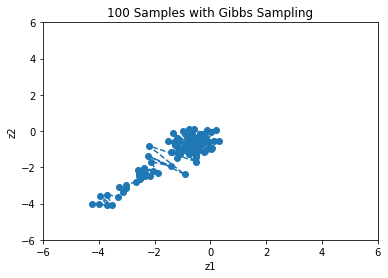

<Figure size 432x288 with 0 Axes>

In [9]:
samples = gibbs_sampling(mu, cov, size=100)
plt.title(f"100 Samples with Gibbs Sampling")
plt.scatter(samples[:, 0], samples[:, 1])
plt.plot(samples[:, 0], samples[:, 1], '--')
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.xlabel("z1")
plt.ylabel("z2")
# plt.savefig(f'100_gibbs.PDF')
plt.show()
plt.clf()

## 2c) Implement HMC with Leapfrog

In [16]:
%%time

def joint_dist(z):
    cov = np.array([[3, 2.9], [2.9, 3]])
    mu = np.array([0, 0])
    return 0.5 * (z - mu).T @ np.linalg.inv(cov) @ (z - mu)
    
def energy(z, r):
    return -np.log(joint_dist(z) + 1e-5) + (0.5 * r.T @ r)  # avoid divide by zero in log

def compute_dz(z):
    cov = np.array([[3, 2.9], [2.9, 3]])
    mu = np.array([0, 0])
    return -np.linalg.inv(cov) @ (z - mu)

def leap_frog(z, r, L, eps):
    dz = -compute_dz(z)
    for _ in range(L):
        r -= 0.5 * eps * dz
        z += eps * r  # s_i = 1
        dz = -compute_dz(z)
        r -= 0.5 * eps * dz
    return z, r, dz

def hybrid_monte_carlo(start, N, z, eps=0.1, L=10):
    for i in range(start, start + N):
        u = np.random.uniform(low=0.0, high=1.0)
        r = np.random.normal(0.0, 1.0, 2)  # s_i = 1
        z_, r_, dz = leap_frog(z[i], r, L, eps)
        r_ = -r_
        if u < np.minimum(1, np.exp(-energy(z_, r_) + energy(z[i], r))):
            z[i + 1] = z_

print(f'Running Hybrid Monte Carlo with eps={e}')
N = 100
z = np.zeros((N + 1, 2))
hybrid_monte_carlo(0, N, z, eps=0.1, L=20)
print(f'Retrieved Samples with eps={e}')

Running Hybrid Monte Carlo with eps=0.5
Retrieved Samples with eps=0.5
Wall time: 97 ms


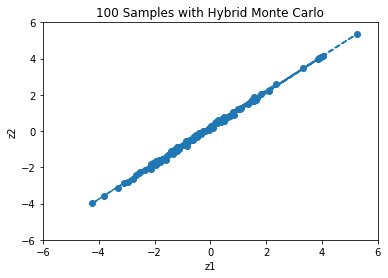

<Figure size 432x288 with 0 Axes>

In [17]:
plt.title(f"100 Samples with Hybrid Monte Carlo")
plt.scatter(z[:, 0], z[:, 1])
plt.plot(z[:, 0], z[:, 1], '--')
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.xlabel("z1")
plt.ylabel("z2")
# plt.savefig(f'100_hybrid_monte_carlo.PDF')
plt.show()
plt.clf()

# Problem 3

## 3a) Bayesian Logistic Regression

In [4]:
from numpy import genfromtxt
train = genfromtxt('./data/bank-note/train.csv', delimiter=',')
ones = np.ones(len(train))
train_X = np.c_[ones, train[:, :4]]
train_Y = train[:, 4]
test = genfromtxt('./data/bank-note/test.csv', delimiter=',')
ones = np.ones(len(test))
test_X = np.c_[ones, test[:, :4]]
test_Y = test[:, 4]

The joint probability for the bayesian logisitc regression model is $p(t, w, x) = p(x, t|w) * p(w) = \Pi_{n=1}^{N}y_n^{t_n} * {1 - y_n}^{1 - t_n} * \mathcal{N}(0, 1)$. Replacing $y_n$ with $\sigma(w^T\phi_n)$ yields $p(t, w, x) = p(x, t|w) * p(w) = \Pi_{n=1}^{N}\sigma(w^T\phi_n)^{t_n} * {1 - \sigma(w^T\phi_n)}^{1 - t_n} * \mathcal{N}(0, 1)$, which is the joint probability of the logistic regression model. We take the log of the prior to reduce the runtime.

In [77]:
%%time

BURN = 100000
N = 10000
L = [10, 20, 50]
eps = [0.005, 0.01, 0.02, 0.05]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_joint_dist(t, w, x):
    pred = sigmoid(x @ w)
    return (t @ np.log(pred + 1e-5)) + ((1 - t) @ np.log(1 - pred  + 1e-5)) - (0.5 * (w.T @ w))
    
def energy(t, w, x, r):
    return -log_joint_dist(t, w, x) + (0.5 * r.T @ r)  # avoid divide by zero in log

def compute_dw(t, w, x, y):
    return x.T @ (y - t) + w

def leap_frog(t, x, w, r, L, eps):
    y = sigmoid(x @ w)
    dw = compute_dw(t, w, x, y)
    for _ in range(L):
        r -= 0.5 * eps * dw
        w += eps * r  # s_i = 1
        y = sigmoid(x @ w)
        dw = compute_dw(t, w, x, y)
        r -= 0.5 * eps * dw
    return w, r

def hybrid_monte_carlo(X, Y, w, start, N, eps=0.1, L=10):
    sampled_weights = []
    accepted = 0
    for i in range(start, start + N):
        u = np.random.uniform(low=0.0, high=1.0)
        r = np.random.normal(0.0, 1.0, w.shape[0])  # s_i = 1
        w_ = np.copy(w)
        r_ = np.copy(r)
        w_, r_ = leap_frog(Y, X, w_, r_, L, eps)
        r_ = -r_
        if u < np.minimum(1, np.exp(-energy(Y, w_, X, r_) + energy(Y, w, X, r))):
            accepted += 1
            w = w_
        if i % 10 == 0:
            sampled_weights.append(w)
    return sampled_weights, accepted / N
    
def compute_test_metrics(weights, test_X, test_Y):
    accs = np.zeros(len(weights))
    llh = np.zeros(len(weights))
    for i in range(len(weights)):
        # accuracy
        pred = sigmoid(test_X @ weights[i])
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        accs[i] = np.sum(pred == test_Y) / pred.shape[0]
        # llh
        pred = sigmoid(test_X @ weights[i])
        llh_ = (test_Y @ np.log(pred + 1e-5)) + ((1 - test_Y) @ np.log(1 - pred  + 1e-5))
        llh[i] = llh_
    return np.mean(accs), np.mean(llh)

results = []
for l in L:
    for e in eps:
        print(f'Running Hybrid Monte Carlo with eps={e} and L={l}')
        w = np.zeros((train_X.shape[1]))
        _, __ = hybrid_monte_carlo(train_X, train_Y, w, 0, BURN, eps=e, L=l)
        print(f'Completed Burn-In with eps={e} and L={l}')
        weights, accepted = hybrid_monte_carlo(train_X, train_Y, w, BURN, N, eps=e, L=l)
        print(f'Retrieved Samples with eps={e} and L={l}')
        acc, llh = compute_test_metrics(weights, test_X, test_Y)
        print(f'With eps={e} and L={l}: Test Accuracy={acc:.2f} Predictive Log-Likelihood={llh: .2f} Accept Rate: {accepted: .2f}\n')
        results.append((e, l, acc, llh, accepted))

Running Hybrid Monte Carlo with eps=0.005 and L=10
Completed Burn-In with eps=0.005 and L=10
Retrieved Samples with eps=0.005 and L=10
With eps=0.005 and L=10: Test Accuracy=0.99 Predictive Log-Likelihood=-15.95 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.01 and L=10
Completed Burn-In with eps=0.01 and L=10
Retrieved Samples with eps=0.01 and L=10
With eps=0.01 and L=10: Test Accuracy=0.99 Predictive Log-Likelihood=-15.53 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.02 and L=10
Completed Burn-In with eps=0.02 and L=10
Retrieved Samples with eps=0.02 and L=10
With eps=0.02 and L=10: Test Accuracy=0.99 Predictive Log-Likelihood=-15.59 Accept Rate:  0.98

Running Hybrid Monte Carlo with eps=0.05 and L=10
Completed Burn-In with eps=0.05 and L=10
Retrieved Samples with eps=0.05 and L=10
With eps=0.05 and L=10: Test Accuracy=0.44 Predictive Log-Likelihood=-346.56 Accept Rate:  0.00

Running Hybrid Monte Carlo with eps=0.005 and L=20
Completed Burn-In with eps=0.005

List a table showing different combinations
of ε and L and the resulting predictive accuracy, predictive log-likelihood, and acceptance rate.
What do you observe and conclude?

For the most part, the hybrid monte carlo approach performs well, achieving almost 100% accuracy. Note that in all these cases the accept rate is near 100%. On the other hand, for $L \in {10, 20, 50} s.t. L > 10$ with $\epsilon = 0.005$, the accuracy drops signifcantly (roughly 44%). This is due to the fact that the acceptance rate drops to $0$, which is direct consequence of reducing $\epsilon$, which, in turn, reduces the change in updated parameters. As a result, the difference in energy approaches zero, hence, most updates are rejected. 

Running Hybrid Monte Carlo with eps=0.005 and L=10
Completed Burn-In with eps=0.005 and L=10
Retrieved Samples with eps=0.005 and L=10
With eps=0.005 and L=10: Test Accuracy=0.99 Predictive Log-Likelihood=-15.95 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.01 and L=10
Completed Burn-In with eps=0.01 and L=10
Retrieved Samples with eps=0.01 and L=10
With eps=0.01 and L=10: Test Accuracy=0.99 Predictive Log-Likelihood=-15.53 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.02 and L=10
Completed Burn-In with eps=0.02 and L=10
Retrieved Samples with eps=0.02 and L=10
With eps=0.02 and L=10: Test Accuracy=0.99 Predictive Log-Likelihood=-15.59 Accept Rate:  0.98

Running Hybrid Monte Carlo with eps=0.05 and L=10
Completed Burn-In with eps=0.05 and L=10
Retrieved Samples with eps=0.05 and L=10
With eps=0.05 and L=10: Test Accuracy=0.44 Predictive Log-Likelihood=-346.56 Accept Rate:  0.00

Running Hybrid Monte Carlo with eps=0.005 and L=20
Completed Burn-In with eps=0.005 and L=20
Retrieved Samples with eps=0.005 and L=20
With eps=0.005 and L=20: Test Accuracy=0.99 Predictive Log-Likelihood=-15.55 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.01 and L=20
Completed Burn-In with eps=0.01 and L=20
Retrieved Samples with eps=0.01 and L=20
With eps=0.01 and L=20: Test Accuracy=0.99 Predictive Log-Likelihood=-15.48 Accept Rate:  0.99

Running Hybrid Monte Carlo with eps=0.02 and L=20
Completed Burn-In with eps=0.02 and L=20
Retrieved Samples with eps=0.02 and L=20
With eps=0.02 and L=20: Test Accuracy=0.99 Predictive Log-Likelihood=-15.42 Accept Rate:  0.98

Running Hybrid Monte Carlo with eps=0.05 and L=20
Completed Burn-In with eps=0.05 and L=20
Retrieved Samples with eps=0.05 and L=20
With eps=0.05 and L=20: Test Accuracy=0.44 Predictive Log-Likelihood=-346.56 Accept Rate:  0.00

Running Hybrid Monte Carlo with eps=0.005 and L=50
Completed Burn-In with eps=0.005 and L=50
Retrieved Samples with eps=0.005 and L=50
With eps=0.005 and L=50: Test Accuracy=0.99 Predictive Log-Likelihood=-15.55 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.01 and L=50
Completed Burn-In with eps=0.01 and L=50
Retrieved Samples with eps=0.01 and L=50
With eps=0.01 and L=50: Test Accuracy=0.99 Predictive Log-Likelihood=-15.45 Accept Rate:  1.00

Running Hybrid Monte Carlo with eps=0.02 and L=50
Completed Burn-In with eps=0.02 and L=50
Retrieved Samples with eps=0.02 and L=50
With eps=0.02 and L=50: Test Accuracy=0.99 Predictive Log-Likelihood=-15.46 Accept Rate:  0.98

Running Hybrid Monte Carlo with eps=0.05 and L=50
Completed Burn-In with eps=0.05 and L=50
Retrieved Samples with eps=0.05 and L=50
With eps=0.05 and L=50: Test Accuracy=0.44 Predictive Log-Likelihood=-346.56 Accept Rate:  0.00

## 3c) Bayesian Neural Network 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SampleDistribution(nn.Module):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = nn.Parameter(mu)
        self.rho = nn.Parameter(rho)
        self.normal = torch.distributions.Normal(0,1)
        self.eps = torch.Tensor(self.normal.sample(self.rho.shape))

    def sample(self):
        self.eps = torch.Tensor(self.normal.sample(self.rho.shape))
        return self.mu + self.rho * self.eps

    def log_posterior(self, w):
        lp = (-np.log(np.sqrt(2 * torch.pi))) - torch.log(self.rho) - (((w - self.mu)**2) / (2 * (self.rho**2)))
        return lp.sum()
    
class PriorDistribution(nn.Module):
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.Normal(0, 1)

    def log_prior(self, w):
        return (self.prior.log_prob(w) - 0.5).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLinear, self).__init__()
        self.in_features  = in_features
        self.out_features = out_features
        # Init Bayesian Params
        normalizer = 1 / np.sqrt(self.in_features)
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(normalizer * torch.ones (out_features, in_features))
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_rho = nn.Parameter(normalizer * torch.ones(out_features))
        self.weight_post = SampleDistribution(self.weight_mu, self.weight_rho)
        self.bias_post = SampleDistribution(self.bias_mu, self.bias_rho) 
        # Initialize Prior and Posterior
        self.weight_prior = PriorDistribution()
        self.bias_prior = PriorDistribution()
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x): 
        if self.training:
            w = self.weight_post.sample()
            b = self.bias_post.sample()
            self.log_prior = self.weight_prior.log_prior(w) + self.bias_prior.log_prior(b)
            self.log_variational_posterior = self.weight_post.log_posterior(w) + self.bias_post.log_posterior(b)
        else:
            w = self.weight_post.mu
            b = self.bias_post.mu
            self.log_prior = 0
            self.log_variational_posterior = 0
        return F.linear(x, w, b)

class BayesianNN(nn.Module):
    def __init__(self, input_dim=5, output_dim=2, hidden_nodes=20, activation="relu", out_activation="softmax"):
        super(BayesianNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_nodes = hidden_nodes
        self.input = BayesianLinear(input_dim, self.hidden_nodes)
        self.hidden = BayesianLinear(self.hidden_nodes, self.hidden_nodes)
        self.output = BayesianLinear(self.hidden_nodes, output_dim)
        self.layers = [self.input, self.hidden, self.output]
        self.activation = nn.ReLU() if activation == "relu" else nn.Tanh()
        self.out_activation = nn.Sigmoid() if out_activation == "sigmoid" else nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.input(x)
        out = self.activation(out)
        out = self.hidden(out)
        out = self.activation(out)
        out = self.output(out)
        return F.log_softmax(out, dim=1)

    def sample_elbo(self, x, y, num_samples=100):
        outputs = torch.zeros(num_samples, x.size(dim=0), 2)
        log_priors = torch.zeros(num_samples)
        log_variational_posteriors = torch.zeros(num_samples)
        hits = torch.zeros(num_samples)
        for i in range(num_samples):
            outputs[i] = self.forward(x)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            preds = outputs[i].argmax(dim=1)
            hits[i] = preds.eq(y.view_as(preds)).sum()
        log_prior = log_priors.mean()
        lvp = log_variational_posteriors.mean()
        acc = hits.mean() / y.size(dim=0)
        output = outputs.mean(dim=0)
        loss = F.nll_loss(output, y, reduction='mean')
        return loss, acc, log_prior, lvp
    
    def log_prior(self):
        prior = 0
        for layer in self.layers:
            prior += layer.log_prior
        return prior

    def log_variational_posterior(self):
        posterior = 0
        for layer in self.layers:
            posterior += layer.log_variational_posterior
        return posterior

In [5]:
def train(model, X, Y, lr, num_epochs=1000, num_samples=100):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_epochs):
        model.zero_grad()
        loss, acc, lp, lvp = model.sample_elbo(X, Y, num_samples=num_samples)
        loss.backward()
        opt.step()
        if i % 100 == 0:
            print(f'Epoch: {i+1} Loss (nll): {loss} Train Accuracy: {acc}')
    print(f'Epoch: {1000} Loss (nll): {loss} Train Accuracy: {acc}')

def test(model, X, Y, num_samples=100):
    model.eval()
    with torch.no_grad():
        model.zero_grad()
        loss, acc, lp, lvp = model.sample_elbo(X, Y, num_samples)
        print(f'Final Test Loss (nll): {loss} Accuracy: {acc}')
    return acc, -loss.item()
        
def train_step(model, X, Y, opt, step, num_samples=100):
    model.train()
    model.zero_grad()
    loss, acc, lp, lvp = model.sample_elbo(X, Y, num_samples)
    loss.backward()
    opt.step()
    if step % 100 == 0:
        print(f'Training Epoch: {step+1} Loss (nll): {loss} Accuracy: {acc}')
    return -loss.item(), acc

def test_step(model, X, Y, step, num_samples=100):
    model.eval()
    with torch.no_grad():
        model.zero_grad()
        loss, acc, lp, lvp = model.sample_elbo(X, Y, num_samples)
        if step % 100 == 0:
            print(f'Testing Epoch: {step+1} Loss (nll): {loss} Accuracy: {acc}')
    return -loss.item(), acc

### Evaluating All Combinations of Hyperparams

In [ ]:
%%time

# init data
train_data = np.genfromtxt('./data/bank-note/train.csv', delimiter=',')
ones = np.ones(len(train_data))
train_X = np.c_[ones, train_data[:, :4]]
train_Y = train_data[:, 4]
test_data = np.genfromtxt('./data/bank-note/test.csv', delimiter=',')
ones = np.ones(len(test_data))
test_X = np.c_[ones, test_data[:, :4]]
test_Y = test_data[:, 4]
train_X, train_Y, test_X, test_Y = torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long(), torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long()

# hyper params
learning_rates = [1e-3, 0.5e-3, 1e-4, 1e-5]
num_hidden_nodes = [10, 20, 50]
activations = ["relu", "tanh"]

# train and test model
results = {}
for a in activations:
    results[a] = {}
    for n in num_hidden_nodes:
        results[a][n] = {}
        best_acc = 0
        best_ll = 0
        for lr in learning_rates:
            print(f"Training BNN on {device} with Learning Rate = {lr:.5f}, Activation = {a}, and Number of Hidden Nodes: {n}")
            model = BayesianNN(hidden_nodes=n, activation=a, out_activation="sigmoid")
            train(model, train_X, train_Y, lr)
            acc, ll = test(model, test_X, test_Y)
            if acc > best_acc:
                best_acc = acc
                best_ll = ll
        results[a][n][lr] = (best_acc, best_ll)

Training BNN on cuda with Learning Rate = 0.00100, Activation = relu, and Number of Hidden Nodes: 10
Epoch: 1 Loss (nll): 1.180888056755066 Train Accuracy: 0.5074770450592041
Epoch: 101 Loss (nll): 0.7598497867584229 Train Accuracy: 0.5148853063583374
Epoch: 201 Loss (nll): 0.7017593383789062 Train Accuracy: 0.5381651520729065
Epoch: 301 Loss (nll): 0.6920708417892456 Train Accuracy: 0.5462729334831238
Epoch: 401 Loss (nll): 0.6956225037574768 Train Accuracy: 0.5314105749130249
Epoch: 501 Loss (nll): 0.6952182650566101 Train Accuracy: 0.5388532280921936
Epoch: 601 Loss (nll): 0.6920781135559082 Train Accuracy: 0.5447935461997986
Epoch: 701 Loss (nll): 0.681064248085022 Train Accuracy: 0.5478440523147583
Epoch: 801 Loss (nll): 0.6655107736587524 Train Accuracy: 0.5489678978919983
Epoch: 901 Loss (nll): 0.3950919806957245 Train Accuracy: 0.8685092329978943
Epoch: 1000 Loss (nll): 0.1765749752521515 Train Accuracy: 0.9771100878715515
Final Test Loss (nll): 0.1667460948228836 Accuracy: 0.9

In [24]:
print(results)

{'relu': {10: {}}}


The best results for each combination of paramters is listed above. As we can see, all settings achieve almost 100% accuracy; however decreasing the learning rate too much often led to poor results. For example, consider a BNN with tanh activation, a learning rate of 1e-5, and 50 hidden nodes. This network achieved a final accruacy of 0.55 on the testset with a negative log-likelihood loss of 0.69 after 1000 epochs. In comparison to our top results, we can see that this result is not very good. When the learning rate was kept somewhat larger e.g. 1e-3, the BNN was more likely to attain higher results.

### Evaluating Tanh with 20 Hidden Nodes Per Epoch

In [7]:
# init data
train_data = np.genfromtxt('./data/bank-note/train.csv', delimiter=',')
ones = np.ones(len(train_data))
train_X = np.c_[ones, train_data[:, :4]]
train_Y = train_data[:, 4]
test_data = np.genfromtxt('./data/bank-note/test.csv', delimiter=',')
ones = np.ones(len(test_data))
test_X = np.c_[ones, test_data[:, :4]]
test_Y = test_data[:, 4]
train_X, train_Y, test_X, test_Y = torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long(), torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long()

# train and test model w/ specific params
num_epochs = 1000
train_ll = []
test_ll = []
model = BayesianNN(hidden_nodes=20, activation="tanh")
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(num_epochs):
    train_ll.append(train_step(model, train_X, train_Y, opt, i)[0])
    test_ll.append(test_step(model, test_X, test_Y, i)[0])

Training Epoch: 1 Loss (nll): 0.7921524047851562 Accuracy: 0.49780961871147156
Testing Epoch: 1 Loss (nll): 0.6930314898490906 Accuracy: 0.5580000281333923
Training Epoch: 101 Loss (nll): 0.7288805246353149 Accuracy: 0.507362425327301
Testing Epoch: 101 Loss (nll): 0.687121570110321 Accuracy: 0.5580000281333923
Training Epoch: 201 Loss (nll): 0.7010459303855896 Accuracy: 0.5338990688323975
Testing Epoch: 201 Loss (nll): 0.6862884163856506 Accuracy: 0.5580000281333923
Training Epoch: 301 Loss (nll): 0.6913526058197021 Accuracy: 0.5383486151695251
Testing Epoch: 301 Loss (nll): 0.685682475566864 Accuracy: 0.5580000281333923
Training Epoch: 401 Loss (nll): 0.687079906463623 Accuracy: 0.5370298027992249
Testing Epoch: 401 Loss (nll): 0.6846369504928589 Accuracy: 0.5580000281333923
Training Epoch: 501 Loss (nll): 0.682540237903595 Accuracy: 0.5580963492393494
Testing Epoch: 501 Loss (nll): 0.6665480732917786 Accuracy: 0.5580000281333923
Training Epoch: 601 Loss (nll): 0.23352430760860443 Ac

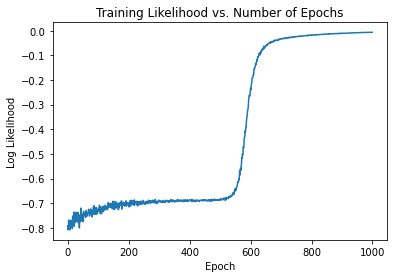

<Figure size 432x288 with 0 Axes>

In [8]:
plt.title(f"Training Likelihood vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, train_ll)
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.savefig(f'LikelihoodVEpochTrain.PDF')
plt.show()
plt.clf()

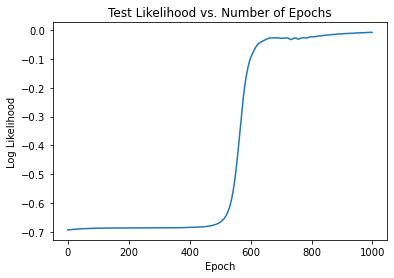

<Figure size 432x288 with 0 Axes>

In [9]:
plt.title(f"Test Likelihood vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, test_ll)
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.savefig(f'LikelihoodVEpochTest.PDF')
plt.show()
plt.clf()

Based on the results, we see that on both the train set and test set, the BNN with tanh activation and 20 hidden nodes achieves near optimal results. This can be seen by the fact the network tends to converge to a negative log-likelihood loss of 0, which indicates that there is no ambiguity in the network's ability to predict the correct classification label, i.e., it is confident in its classification. One thing to note is that the train loss seems to a bit more noisier earlier on; however, this can be due to a "cold start" like problem with initializing the distribution parameters from scratch. 

## 3d) Compare the approaches

Based on the results, it seems like both models are able to almost perfectly represent the test data. However, while the Bayesian regression model achieves good results, it seems a bit too sensitive to initialization parameters, e.g., epsilon. For example, choosing the wrong epsilon value results in very poor accuracy. We see somewhat similar behavior with a poor choice in learning rate for the BNN, but this can be chalked up to the BNN not converging. It's likely that the BNN would achieve higher results if it was able to run for more epochs even with poor settings. Another thing to look at would be total runtime. Just running both these experiments on a CPU results in long runtimes. If you are forced to utilize a CPU, it may be better to use the Bayesian regression model, since the total runtime is a much smaller (on my PC the BNN experiment took around 3h while the regression experiment took around 30min).

# Problem 4

In [15]:
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class SampleDistribution(nn.Module):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = nn.Parameter(mu).to(device)
        self.rho = nn.Parameter(rho).to(device)
        self.normal = torch.distributions.Normal(0,1)
        self.eps = torch.Tensor(self.normal.sample(self.rho.shape)).to(device)

    def sample(self):
        self.eps = torch.Tensor(self.normal.sample(self.rho.shape)).to(device)
        return self.mu + self.rho * self.eps

    def log_posterior(self, w):
        lp = (-np.log(np.sqrt(2 * torch.pi))) - torch.log(self.rho) - (((w - self.mu)**2) / (2 * (self.rho**2)))
        return lp.sum()
    
class PriorDistribution(nn.Module):
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.Normal(0, 1)

    def log_prior(self, w):
        return (self.prior.log_prob(w) - 0.5).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLinear, self).__init__()
        self.in_features  = in_features
        self.out_features = out_features
        # Init Bayesian Params
        normalizer = 1 / np.sqrt(self.in_features)
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(normalizer * torch.ones (out_features, in_features))
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_rho = nn.Parameter(normalizer * torch.ones(out_features))
        self.weight_post = SampleDistribution(self.weight_mu, self.weight_rho)
        self.bias_post = SampleDistribution(self.bias_mu, self.bias_rho) 
        # Initialize Prior and Posterior
        self.weight_prior = PriorDistribution()
        self.bias_prior = PriorDistribution()
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x): 
        if self.training:
            w = self.weight_post.sample()
            b = self.bias_post.sample()
            self.log_prior = self.weight_prior.log_prior(w) + self.bias_prior.log_prior(b)
            self.log_variational_posterior = self.weight_post.log_posterior(w) + self.bias_post.log_posterior(b)
        else:
            w = self.weight_post.mu
            b = self.bias_post.mu
            self.log_prior = 0
            self.log_variational_posterior = 0
        return F.linear(x, w, b)

class BayesianNN(nn.Module):
    def __init__(self, input_dim=5, output_dim=2, hidden_nodes=20, activation="relu", out_activation="softmax"):
        super(BayesianNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_nodes = hidden_nodes
        self.input = BayesianLinear(input_dim, self.hidden_nodes)
        self.hidden = BayesianLinear(self.hidden_nodes, self.hidden_nodes)
        self.output = BayesianLinear(self.hidden_nodes, output_dim)
        self.flatten = nn.Flatten()
        self.layers = [self.input, self.hidden, self.output]
        self.activation = nn.ReLU() if activation == "relu" else nn.Tanh()
        self.out_activation = nn.Sigmoid() if out_activation == "sigmoid" else nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.flatten(x)
        out = self.input(out)
        out = self.activation(out)
        out = self.hidden(out)
        out = self.activation(out)
        out = self.output(out)
        return F.log_softmax(out, dim=1)

    def sample_elbo(self, x, y, num_samples=100):
        x = x.to(device)
        y = y.to(device)
        outputs = torch.zeros(num_samples, x.size(dim=0), self.output_dim).to(device)
        log_priors = torch.zeros(num_samples).to(device)
        log_variational_posteriors = torch.zeros(num_samples).to(device)
        hits = torch.zeros(num_samples).to(device)
        for i in range(num_samples):
            outputs[i] = self.forward(x)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            preds = outputs[i].argmax(dim=1)
            hits[i] = preds.eq(y.view_as(preds)).sum()
        log_prior = log_priors.mean()
        lvp = log_variational_posteriors.mean()
        acc = hits.mean() / y.size(dim=0)
        output = outputs.mean(dim=0)
        loss = F.nll_loss(output, y, reduction='mean')
        if self.training:
            loss.backward()
        return loss.item(), acc, log_prior, lvp
    
    def log_prior(self):
        prior = 0
        for layer in self.layers:
            prior += layer.log_prior
        return prior

    def log_variational_posterior(self):
        posterior = 0
        for layer in self.layers:
            posterior += layer.log_variational_posterior
        return posterior

cuda


In [15]:
from torch.utils.data import Dataset, DataLoader, random_split

class MNIST(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.X[idx], self.Y[idx])

In [16]:
import struct

def load_mnist_img(path):
    with open(path,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
        return torch.from_numpy(data) / 126
    
def load_mnist_labels(path):
    with open(path,'rb') as f:
        magic, size = struct.unpack('>II', f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8)).newbyteorder(">") 
        return torch.from_numpy(data)

def load_mnist():
    # Source: https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format
    train_imgs = load_mnist_img('./mnist/train-images.idx3-ubyte')
    train_labels = load_mnist_labels('./mnist/train-labels.idx1-ubyte')
    test_imgs = load_mnist_img('./mnist/t10k-images.idx3-ubyte')
    test_labels = load_mnist_labels('./mnist/t10k-labels.idx1-ubyte')
    return train_imgs, train_labels, test_imgs, test_labels

train_X, train_Y, test_X, test_Y = load_mnist()
train_MNIST = MNIST(train_X, train_Y)
test_MNIST = MNIST(test_X, test_Y)

In [17]:
batch_size = 32
train_MNIST_, val_MNIST = random_split(train_MNIST, [50000, 10000])
all_train_loader = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_MNIST_, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_MNIST, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False)

## 4a) Factorized Gaussian Posterior

In [17]:
def train_one_epoch_BNN(model, dataloader, opt, num_samples=10):
    total_loss = 0
    total_acc = 0
    total_lp = 0
    total_lvp = 0
    num_batch = len(dataloader)
    for i, data in enumerate(dataloader):
        x, y = data
        model.zero_grad()
        loss, acc, lp, lvp = model.sample_elbo(x, y, num_samples=num_samples)
        opt.step()
        total_loss += loss
        total_acc += acc
        total_lp += lp
        total_lvp += lvp
        if i % 100 == 0:
            print(f'Batch: {i+1} Loss (nll): {loss} Train Accuracy: {acc}')
    return total_loss / num_batch, total_acc / num_batch, total_lp / num_batch, total_lvp / num_batch

def test_one_epoch_BNN(model, dataloader, num_samples=10):
    total_loss = 0
    total_acc = 0
    total_lp = 0
    total_lvp = 0
    num_batch = len(dataloader)
    for i, data in enumerate(dataloader):            
        x, y = data
        loss, acc, lp, lvp = model.sample_elbo(x, y, num_samples=num_samples)
        total_loss += loss
        total_acc += acc
        total_lp += lp
        total_lvp += lvp
        if i % 100 == 0:
            print(f'Batch: {i+1} Loss (nll): {loss} Test Accuracy: {acc}')
    return total_loss / num_batch, total_acc / num_batch, total_lp / num_batch, total_lvp / num_batch

def train_batch(model, dataloader, lr, num_epochs=1000, num_samples=10):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_epochs):
        model.zero_grad()
        loss, acc, lp, lvp = train_one_epoch_BNN(model, dataloader, opt, num_samples=num_samples)
        if i % 100 == 0:
            print(f'Epoch: {i+1} Loss (nll): {loss} Train Accuracy: {acc}')
    print(f'Epoch: {1000} Loss (nll): {loss} Train Accuracy: {acc}')

def test_batch(model, dataloader, num_samples=10):
    model.eval()
    with torch.no_grad():
        model.zero_grad()
        loss, acc, lp, lvp = test_one_epoch_BNN(model, dataloader, num_samples=num_samples)
        print(f'Final Test Loss (nll): {loss} Accuracy: {acc}')
    return acc, -loss
        
def train_batch_step(model, dataloader, opt, step, num_samples=10):
    model.train()
    model.zero_grad()
    loss, acc, lp, lvp = train_one_epoch_BNN(model, dataloader, opt, num_samples=num_samples)
    if step % 100 == 0:
        print(f'Training Epoch: {step+1} Loss (nll): {loss} Accuracy: {acc}')
    return -loss, acc

def test_batch_step(model, dataloader, step, num_samples=10):
    model.eval()
    with torch.no_grad():
        model.zero_grad()
        loss, acc, lp, lvp = test_one_epoch_BNN(model, dataloader, num_samples=num_samples)
        if step % 100 == 0:
            print(f'Testing Epoch: {step+1} Loss (nll): {loss} Accuracy: {acc}')
    return -loss, acc

In [18]:
%%time

# hyper params
learning_rates = [1e-3, 1e-4, 1e-5]
num_hidden_nodes = [400, 800, 1200]
activations = ["relu", "tanh"]

# train and test model
results = {}
for a in activations:
    results[a] = {}
    for n in num_hidden_nodes:
        results[a][n] = {}
        best_acc = 0
        best_ll = 0
        for lr in learning_rates:
            print(f"Training BNN with Learning Rate = {lr:.5f}, Activation = {a}, and Number of Hidden Nodes: {n}")
            model = BayesianNN(input_dim=784, output_dim=10, hidden_nodes=n, activation=a, out_activation="softmax")
            model.to(device)
            train_batch(model, train_loader, lr, num_samples=10)
            acc, ll = test_batch(model, val_loader, num_samples=10)
            if acc > best_acc:
                best_acc = acc
                best_ll = ll
        results[a][n][lr] = (best_acc, best_ll)

Training BNN with Learning Rate = 0.00100, Activation = relu, and Number of Hidden Nodes: 400
Batch: 1 Loss (nll): 2.3756632804870605 Train Accuracy: 0.08164062350988388


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 4.60 GiB already allocated; 0 bytes free; 4.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [53]:
print(results)

{'relu': {400: {}}}


TODO: Find best settings and rerun on whole dataset with those and just print out each iter (plot loss and acc over time)

In [ ]:
# %%time

# # train and test model
# model = BayesianNN(input_dim=784, output_dim=10, hidden_nodes=n, activation=a, out_activation="softmax") # use best hidden_dim and activation
# model.to(device)
# train_batch(model, all_train_loader, lr, num_samples=10)  # USE WHOLE dataset and best lr
# acc, ll = test_batch(model, test_loader, num_samples=10)
# print(f'Best Parameters yields an accuracy of {acc:.3f} and a negative log-likelihood of {ll}')

## 4c) Vanilla NN

In [18]:
class VanillaNN(nn.Module):
    def __init__(self, input_dim, output_dim=10, hidden_nodes=400, activation="relu"):
        super(VanillaNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_nodes = hidden_nodes
        self.input = nn.Linear(input_dim, self.hidden_nodes)
        self.hidden1 = nn.Linear(self.hidden_nodes, self.hidden_nodes)
        self.hidden2 = nn.Linear(self.hidden_nodes, self.hidden_nodes)
        self.output = nn.Linear(self.hidden_nodes, output_dim)
        self.flatten = nn.Flatten()
        self.activation = nn.ReLU() if activation == "relu" else nn.Tanh()
        self.out_activation = nn.Softmax(dim=1)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        out = self.flatten(x)
        out = self.input(out)
        out = self.activation(out)
        out = self.hidden1(out)
        out = self.activation(out)
        out = self.hidden2(out)
        out = self.activation(out)
        out = self.output(out)
        return self.out_activation(out)
    
    def run_iter(self, x, y):
        x = x.to(device)
        y = y.to(device)
        outputs = self.forward(x)
        preds = outputs.argmax(dim=1)
        hits = preds.eq(y.view_as(preds)).sum()
        acc = hits / y.size(dim=0)
        loss = self.loss(outputs, y)
        if self.training:
            loss.backward()
        return loss.item(), acc

In [19]:
def train_one_epoch_VNN(model, dataloader, opt):
    total_loss = 0
    total_acc = 0
    num_batch = len(dataloader)
    for i, data in enumerate(dataloader):
        x, y = data
        model.zero_grad()
        loss, acc = model.run_iter(x, y)
        opt.step()
        total_loss += loss
        total_acc += acc
    return total_loss / num_batch, total_acc / num_batch

def test_one_epoch_VNN(model, dataloader):
    total_loss = 0
    total_acc = 0
    num_batch = len(dataloader)
    for i, data in enumerate(dataloader):
        x, y = data
        loss, acc = model.run_iter(x, y)
        total_loss += loss
        total_acc += acc
    return total_loss / num_batch, total_acc / num_batch

def train_VNN(model, dataloader, lr, num_epochs=1000):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_epochs):
        model.zero_grad()
        loss, acc = train_one_epoch_VNN(model, dataloader, opt)
        if i % 100 == 0:
            print(f'Epoch: {i+1} Loss (Cross-Entropy): {loss} Train Accuracy: {acc}')
    print(f'Epoch: {1000} Loss (Cross-Entropy): {loss} Train Accuracy: {acc}')

def test_VNN(model, dataloader):
    model.eval()
    with torch.no_grad():
        model.zero_grad()
        loss, acc = test_one_epoch_VNN(model, dataloader)
        print(f'Final Test Loss (Cross-Entropy): {loss} Accuracy: {acc}')
    return acc, loss

def VNN_train_step(model, dataloader, opt, step):
    model.train()
    model.zero_grad()
    loss, acc = train_one_epoch_VNN(model, dataloader, opt)
    if step % 100 == 0:
        print(f'Training Epoch: {step+1} Loss (Cross-Entropy): {loss} Accuracy: {acc}')
    return acc, loss

def VNN_test_step(model, dataloader, step):
    model.eval()
    with torch.no_grad():
        model.zero_grad()
        loss, acc = test_one_epoch_VNN(model, dataloader)
        if step % 100 == 0:
            print(f'Testing Epoch: {step+1} Loss (Cross-Entropy): {loss} Accuracy: {acc}')
    return acc, loss

In [20]:
%%time

gc.collect()
torch.cuda.empty_cache()

# hyper params
learning_rates = [1e-3, 1e-4, 1e-5]
num_hidden_nodes = [400, 800, 1200]
activations = ["relu", "tanh"]

# train and test model
results = {}
for a in activations:
    results[a] = {}
    for n in num_hidden_nodes:
        results[a][n] = {}
        best_acc = 0
        best_loss = 0
        for lr in learning_rates:
            print(f"Training Vanilla NN with Learning Rate = {lr:.5f}, Activation = {a}, and Number of Hidden Nodes: {n}")
            model = VanillaNN(784, output_dim=10, hidden_nodes=n, activation=a)
            model.to(device)
            train_VNN(model, train_loader, lr)
            acc, loss = test_VNN(model, val_loader)
            if acc > best_acc:
                best_acc = acc
                best_loss = loss
        results[a][n][lr] = (best_acc, best_loss)

Training Vanilla NN with Learning Rate = 0.00100, Activation = relu, and Number of Hidden Nodes: 400
Epoch: 1 Loss (Cross-Entropy): 1.602242536065827 Train Accuracy: 0.859644889831543
Epoch: 101 Loss (Cross-Entropy): 1.6176278737593521 Train Accuracy: 0.8435300588607788
Epoch: 201 Loss (Cross-Entropy): 1.5762739448461942 Train Accuracy: 0.8848768472671509
Epoch: 301 Loss (Cross-Entropy): 1.5762939430244138 Train Accuracy: 0.8848568201065063
Epoch: 401 Loss (Cross-Entropy): 1.576293939668554 Train Accuracy: 0.8848568201065063
Epoch: 501 Loss (Cross-Entropy): 1.576333925499797 Train Accuracy: 0.8848168849945068
Epoch: 601 Loss (Cross-Entropy): 1.576273945380081 Train Accuracy: 0.8848768472671509
Epoch: 701 Loss (Cross-Entropy): 1.5762539517780336 Train Accuracy: 0.8848968148231506
Epoch: 801 Loss (Cross-Entropy): 1.576293939668554 Train Accuracy: 0.8848568201065063
Epoch: 901 Loss (Cross-Entropy): 1.5762339564217869 Train Accuracy: 0.8849168419837952
Epoch: 1000 Loss (Cross-Entropy): 1.5

KeyboardInterrupt: 

In [59]:
print(results)

{'relu': {400: {}}}


TODO: Find best settings and rerun on whole dataset with those and just print out each iter (plot loss and acc over time)

In [ ]:
# # train and test model w/ specific params
# model = VanillaNN(784, output_dim=10, hidden_nodes=n, activation=a) # SET TO BEST HIDDEN and ACTIVATION
# model.to(device)
# train_VNN(model, all_train_loader, lr)  # TRAIN ON WHOLE DATASET with BEST LR
# acc, loss = test_VNN(model, test_loader)
# print(f'Best Parameters yields an accuracy of {acc:.3f} and a cross entropy loss of {loss}')

## 4d) Evaluate the Approaches

### Fixed BNN with 1200 Hidden Nodes and ReLU activation

In [ ]:
# train and test model w/ specific params
num_epochs = 1000
bnn_train_loss = []
bnn_train_acc = []
bnn_test_loss = []
bnn_test_acc = []
model = BayesianNN(784, output_dim=10, hidden_nodes=1200, activation="relu")
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # USE BEST LR HERE
for i in range(num_epochs):
    loss, acc = train_batch_step(model, all_train_loader, opt, i)
    bnn_train_loss.append(loss)
    bnn_train_acc.append(acc)
    loss, acc = test_batch_step(model, test_loader, i)
    bnn_test_loss.append(loss)
    bnn_test_acc.append(acc)

In [ ]:
plt.title(f"Training Loss vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, bnn_train_loss)
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.savefig(f'LLVEpochTrainBNN.PDF')
plt.show()
plt.clf()

In [ ]:
plt.title(f"Training Accuracy vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, bnn_train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(f'AccuracyVEpochTrainBNN.PDF')
plt.show()
plt.clf()

In [ ]:
plt.title(f"Test Loss vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, bnn_test_loss)
plt.xlabel("Epoch")
plt.ylabel("Log Likelihood")
plt.savefig(f'LLVEpochTestBNN.PDF')
plt.show()
plt.clf()

In [ ]:
plt.title(f"Test Accuracy vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, bnn_test_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(f'AccuracyVEpochTestBNN.PDF')
plt.show()
plt.clf()

### Fixed Vanilla NN with 1200 Hidden Nodes and ReLU activation

In [ ]:
# train and test model w/ specific params
num_epochs = 1000
train_loss = []
train_acc = []
test_loss = []
test_acc = []
model = VanillaNN(784, output_dim=10, hidden_nodes=1200, activation="relu")
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)  # USE BEST LR HERE
for i in range(num_epochs):
    acc, loss = VNN_train_step(model, all_train_loader, opt, i)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = VNN_test_step(model, test_loader, i)
    test_loss.append(loss)
    test_acc.append(acc)

In [ ]:
plt.title(f"Training Loss vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.savefig(f'CrossEntropyVEpochTrainVNN.PDF')
plt.show()
plt.clf()

In [ ]:
plt.title(f"Training Accuracy vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, train_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(f'AccuracyVEpochTrainVNN.PDF')
plt.show()
plt.clf()

In [ ]:
plt.title(f"Test Loss vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, test_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.savefig(f'CrossEntropyVEpochTestVNN.PDF')
plt.show()
plt.clf()

In [ ]:
plt.title(f"Test Accuracy vs. Number of Epochs")
x_ = np.arange(0, 1000)
plt.plot(x_, test_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(f'AccuracyVEpochTestVNN.PDF')
plt.show()
plt.clf()